## Obj: Implement linear regression from scratch using car price dataset

This is the first notebook from the series __From Scratch__, where i try to code machine learning algorithms from scratch (just numpy and math)

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression  # For crosschecking result
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## The training Data

In [2]:
df = pd.read_csv("CarPrice_Assignment.csv")
df["mpgcombined"] = df["citympg"] + df["highwaympg"]
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,mpgcombined
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,48
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,48
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,45
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,54
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0,51
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0,44
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0,41
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,idi,3.01,3.40,23.0,106,4800,26,27,22470.0,53


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

# Univariate Linear Regression
predicting price using horsepower

In [67]:
hp = df["horsepower"].to_numpy().reshape(-1, 1)
price = df["price"].to_numpy().reshape(-1, 1)

### Analytic Approach

This is the cost function to be minimized
$$ J(w,b) = \frac{1}{2m}\sum_{i=0}^{m-1}(wx_{(i)}+b-y_{(i)})^{2} $$ 

Since the cost function is convex, the stationary point will most definitely be critical point. Therefore, to minimize the it, we find the $w$ and $b$ such that $\nabla J(w,b)=0$. 

$$\frac{\partial J(w,b)}{\partial w} = \frac{1}{m}\sum_{i=0}^{m-1}(wx_{(i)}^{2}+bx_{(i)}-x_{(i)}y_{(i)}) = 0$$


$$\frac{\partial J(w,b)}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1}(x_{(i)}+b-y_{(i)}) = 0 $$

These results produce two linear equations with two unknowns

$$w\sum_{i=0}^{m-1}x_{(i)}^{2}+\sum_{i=0}^{m-1}bx_{(i)} = \sum_{i=0}^{m-1}x_{(i)}y_{(i)} $$
$$w\sum_{i=0}^{m-1}x_{(i)}+bm = \sum_{i=0}^{m-1}y_{(i)} $$

Solving, preferably using matrices, for w gives

$$w = \frac{m\sum_{i=0}^{m-1}x_{(i)}y_{(i)} - \sum_{i=0}^{m-1}x_{(i)}\sum_{i=0}^{m-1}y_{(i)}}{m\sum_{i=0}^{m-1}x_{(i)}^{2} - (\sum_{i=0}^{m-1}x_{(i)})^{2}}$$

Solving, in terms of w, for b gives

$$b = \bar{y} - w\bar{x}$$

In [14]:
# Creating a simple linear regression object
class AnaUniRegression():
    # Defining the attribute to be the resulting parameter
    def fit(self, feature, target):
        m = len(target)
        sigma_x = feature.sum()
        sigma_y = target.sum()
        sigma_xy = (feature * target).sum()
        sigma_x_sqr = (feature**2).sum()
        w = (m*sigma_xy - sigma_x*sigma_y)/(m*sigma_x_sqr - sigma_x**2)
        b = target.mean() - w*feature.mean()
        self.w = w
        self.b = b
        
    # Defining function for predicting based on the parameter
    def predict(self, data):
        return self.w*data + self.b

#### The resulting parameters

In [15]:
reg = AnaUniRegression()
reg.fit(hp, price)
print(f"w: {reg.w:.3f}")
print(f"b: {reg.b:.3f}")

w: 163.263
b: -3721.761


### Numerical Approach (Gradient Descent)

The cost function decreases the most to the direction of the vector  $\nabla J(w,b)$.

Gradient Descent will find the most efficient baby-step to the global minimum. This is guaranteed to succeed due to the convex nature of the cost function.

The Algorithm:

$$\begin{align*} \text{repeat}&\text{ until the cost function converges:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3} = w - \alpha\frac{1}{m}\sum_{i=0}^{m-1}(wx_{(i)}^{2}+bx_{(i)}-x_{(i)}y_{(i)})  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b} = b - \alpha\frac{1}{m}\sum_{i=0}^{m-1}(x_{(i)}+b-y_{(i)}) \newline \rbrace
\end{align*}$$
where w,b are updated simultaneously

In [28]:
class NumUniReg():
    # Computing the cost function
    def cost_function(self, w, b, feature, target):
        return (1/(2*len(target)))*(((feature*w + b - target)**2).sum())

    # Computing the update for the w parameter
    def update_w(self, w, b, feature, target, alpha_w):
        return w - (alpha_w*(1/len(feature)) * (feature*(feature*w + b - target)).sum())

    # Computing the update for the b parameter
    def update_b(self, w, b, feature, target, alpha_b):
        return b - (alpha_b*(1/len(feature)) * ((w*feature + b - target)).sum())

    # Combining everything to main gradient descent function
    def fit(self, feature, target, iterations, w=0, b=0, alpha_w=0.0001, alpha_b=0.0001):
        cost = []
        for i in range(iterations):
            w, b = self.update_w(w, b, feature, target, alpha_w), self.update_b(w, b, feature, target, alpha_b) 
            # w and b should be updated simultaneously. Otherwise, the input for update_b will not be same as that of w.
            cost.append(self.cost_function(w, b, feature, target))
        self.w = w
        self.b = b
        self.costs = cost

#### The resulting parameters

In [29]:
%%time
reg = NumUniReg()
reg.fit(hp, price, 200000)
print(f"w: {reg.w:.3f}")
print(f"b: {reg.b:.3f}")

w: 160.723
b: -3419.335
CPU times: total: 18.4 s
Wall time: 21 s


This should be better with feature scaling

#### Convergence testing

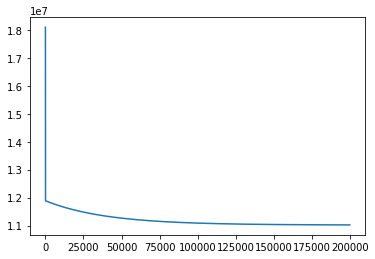

In [30]:
plt.plot(range(200000), reg.costs)
plt.show()

#### Scaling the features

In [68]:
scaler_hp = StandardScaler()
scaler_price = StandardScaler()

scaled_hp = scaler_hp.fit_transform(hp)

In [69]:
%%time
reg = NumUniReg()
reg.fit(scaled_hp, price, 20000, alpha_w=0.001, alpha_b=0.001)
print(f"w: {reg.w:.3f}")
print(f"b: {reg.b:.3f}")

w: 6440.336
b: 13276.711
CPU times: total: 1.44 s
Wall time: 1.53 s


#### Convergence testing

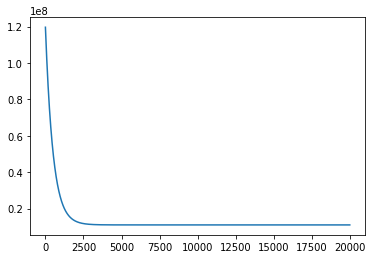

In [71]:
plt.plot(range(20000), reg.costs)
plt.show()

It appears that because the feature and target are very different in terms of scaling, the gradient descent converges very slowly, hence why feature scaling is vital.

# Multiple Linear Regression 
Predicting price using horsepower and engine size

In [72]:
hp_engine = df[["horsepower", "enginesize"]].values
price = df["price"].values.reshape(-1, 1)

### Analytic Closed Form Solution

The model is $ \hat{y} = Xw$ where X is an $n \times (feature+1)$ matrix and w is a $(feature+1) \times 1$ matrix. It is $(feature+1)$ because the constant $b$ is incorporated into $w$, which means the first column of $X$ consists of only ones.


The cost function to be minimized is $ J(\vec{w}) = \frac{1}{2n}(X\vec{w} - \vec{y})^{T}(X\vec{w} - \vec{y}) $, the output of which is a $(feature+1) \times 1$ matrix. To minimized it, we set the $ \frac{\partial{J(\vec{w})}}{\partial{\vec{w}}} = 0 $ or $\nabla{J(\vec{w})}=0$. Since this function produces a scalar, its partial derivative with respect to vector $\vec{w}$ will have the same dimension as that of $\vec{w}$.

$$ J(\vec{w}) = \frac{1}{2n}(X\vec{w} - \vec{y})^{T}(X\vec{w} - \vec{y}) = \frac{1}{2n}(\vec{w}^{T}X^{T}X\vec{w} - \vec{w}^{T}X^{T}\vec{y} - \vec{y}^{T}X\vec{w} + \vec{y}^{T}\vec{y}) $$

$$ \frac{\partial{J(\vec{w})}}{\partial{\vec{w}}} = \frac{1}{2n}(2X^{T}X\vec{w} - 2X^{T}\vec{y}) = \frac{1}{n}X^{T}(X\vec{w} - \vec{y}) $$

Optimize it to solve for  $\vec{w}$

$$ \frac{1}{2n}(2X^{T}X\vec{w} - 2X^{T}\vec{y})=0$$

$$ \vec{w} = (X^{T}X)^{-1} X^{T}\vec{y}  $$


In [41]:
def analytic_multireg(feature, target):
    # feature: n x d numpy array 
    # target: n x 1 numpy array 
    X = np.hstack((np.array([1]*len(target)).reshape(-1,1), feature))
    X_trans = np.transpose(X)
    XX_trans = np.matmul(X_trans, X)
    inv = np.linalg.inv(XX_trans)
    X_transY = np.matmul(X_trans, target)
    return np.matmul(inv, X_transY)

In [46]:
%%time
analytic_multireg(hp_engine, price)

CPU times: total: 0 ns
Wall time: 38.7 ms


array([[-8389.73308932],
       [   58.84742172],
       [  122.44701649]])

### Gradient Descent Numerical Solution (for loop, no vectorization approach)

In [59]:
class GdMultipleLinearRegression():
    
    def dj_dw(self, X, y, diff, n, m):
        result = 0
        for i in range(n):
            result += diff[i] * X[i]  # the X indexing convert to array to 1d (deletes any (,1) in it)
        return (result/n).reshape(-1,1)

    def dj_db(self, X, y, diff, n):
        return 1/n * (diff.sum())

    def err(self, X, y, w, b):
        return np.matmul(X, w) + b - y
    
    def predict(self, data, w, b):
        return np.matmul(data, w) + b
        
    def compute_cost(self, X, y, w, b, n):
        expression = np.matmul(X, w) + b - y
        return (1/(2*n))*(expression*expression).sum()
    
    def fit(self, X, y, iterations, alpha):
        n, m = X.shape
        w = np.zeros((m,1))
        b = 0
        cost = []

        for i in range(iterations):
            diff = self.err(X, y, w, b)
            w = w - alpha*self.dj_dw(X, y, diff, n , m)
            b = b - alpha*self.dj_db(X, y, diff, n)
            cost.append(self.compute_cost(X, y, w, b, n))
        self.w_final = w
        self.b_final = b
        self.cost_process = np.array(cost)

#### Scaling the features

I am scaling the features, as otherwise it would take a long time considering range of the features

In [63]:
scaler = MinMaxScaler(feature_range =(0, 1))
hp_engine_scaled = scaler.fit_transform(hp_engine)

#### Here comes the testing

In [64]:
reg = LinearRegression().fit(hp_engine_scaled, price)
print(f"w: {reg.coef_}")
print(f"b: {reg.intercept_}")

w: [[14123.3812132  32448.45937065]]
b: [1904.2111594]


In [65]:
reg = GdMultipleLinearRegression()
reg.fit(hp_engine_scaled, price, 1000, 1)
print(f"w: {reg.w_final.reshape(-1)}")
print(f"b: {reg.b_final}")

w: [14193.99647495 32373.4646517 ]
b: 1906.3620426522755


## Fully vectorized and numerical implementation.
This involves combining the parameter into a column vector and inserting column of ones to the left of feature data (as in the analytic approach) and use gradient descent for optimization.

$$\begin{align*} \text{repeat}&\text{ until the cost function converges:} \; \lbrace \newline
\;  \vec{w} &= \vec{w} -  \alpha \frac{\partial J(\vec{w})}{\partial \vec{w}} \tag{3} = \vec{w} - \alpha\frac{1}{n}(X^{T}X\vec{w} - X^{T}\vec{y}) =  \newline \rbrace
\end{align*}$$

there's only one parameter to update, since the coefficient and intercept was combined into one vector $\vec{w}$ 

In [86]:
class GdLinearRegression:
    
    def update_parameter (self, feature_n, target, parameter_n):
        total = np.transpose(feature_n) @ feature_n @ parameter_n - np.transpose(feature_n) @ target
        return total/len(target)
    
    def predict (self, data):
        return np.matmul(data, self.parameter_final)
    
    def compute_cost(self, parameter, X, target, n):
        terms = np.transpose(X@parameter - target) @ (X@parameter - target)
        return ((1/(2*n))*terms)[0][0] 

    def fit(self, feature, target, alpha, iterations):
        n, m = feature.shape
        X_filled = np.insert(feature, 0, np.array([1]*n), axis=1)
        parameter = np.zeros((m+1, 1))
        cost = []
        for i in range(iterations):
            parameter = parameter - alpha*self.update_parameter(X_filled, target, parameter)
            cost.append(self.compute_cost(parameter, X_filled, target, n))
        
        self.cost_process = np.array(cost)
        self.parameter_final = parameter
        self.w_final = parameter[1:]
        self.b_final = parameter[0]

### Testing

In [90]:
reg = GdLinearRegression()
reg.fit(hp_engine_scaled, price, 1, 1000)
print(f"w: {reg.w_final.reshape(-1)}")
print(f"b: {reg.b_final}")

w: [14193.99647495 32373.4646517 ]
b: [1906.36204265]


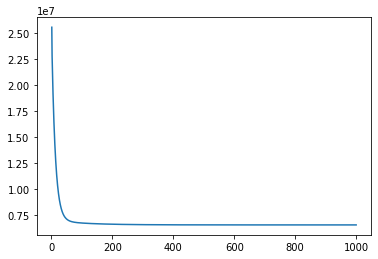

In [91]:
costs = reg.cost_process
plt.plot(range(1, 1001), costs)
plt.show()

### Not a bad start for me :P